In [1]:
suppressMessages(library("rwwa"))

# Obs

In [319]:
varnm <- "tx14x"
nsamp <- 1000

rp <- list("tx14x" = 50, "tn14x" = 20)[[varnm]]

In [320]:
# load GMST time series (annual, 4-year smoothed)
gmst <- read.table("ts/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

cov_f <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_cf <- rbind("pi" = cov_f - 1.3,
                "2000" = cov_f - 0.65,
                "2018" = gmst$gmst[gmst$year == 2018])

## Fit model

In [147]:
fl <- list.files("ts", pattern = varnm, full.names = T)
fl <- fl[!grepl("i1p1", fl)]
fl <- fl[grepl("eobs",fl)]

In [148]:
for (fnm in fl) {
    print(fnm)

    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res-obs_",fnm))
    # if(file.exists(res_fnm)) next
    df <- merge(gmst, load_ts(fnm, col.names = c("year", "tmax")))

    mdl <- fit_ns("gev", "shift", df, "tmax", "gmst")

    if (max(df$year) < 2025) {
        rl_ev <- eff_return_level(mdl, rp = rp, fixed_cov = cov_f)
        mdl <- fit_ns("gev", "shift", df, "tmax", "gmst", ev = rl_ev, ev_year = 2025)
    }

    res <- boot_ci(mdl, cov_f = cov_f, cov_cf = cov_cf, nsamp = nsamp)
    write.csv(res, res_fnm)

    png(gsub("csv", "png", gsub("res/", "fig/", res_fnm)), h = 360, w = 360 * 3); {
        prep_window(c(1,3))
        plot_trend(mdl, ev_year = 2025)
        plot_covtrend(mdl, "gmst", ci_cov = rbind(cov_f, cov_cf), nsamp = 100, ev_x = 0)
        plot_returnlevels(mdl, cov_f, cov_cf["pi",,drop = F])
    }; dev.off()
}

[1] "ts/fs-heatwave_tx14x_eobs.dat"


## Compile obs results

In [149]:
for (varnm in c("tx14x", "tn14x")) {
    res_obs <- t(sapply(list.files("res", pattern = paste0("res-obs.+",varnm), full.names = T), function(fnm) {
        res <- read.csv(fnm, row.names = "X")
        unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
    }))
    
    rownames(res_obs) <- gsub(".csv", "", sapply(strsplit(rownames(res_obs), "_"), "[", 4))
    write.csv(res_obs, paste0("res-obs_",varnm,".csv"))
}

## Table of results

In [280]:
varnm = "tx14x"
eval_cnm <- c("event.magnitude", "return.period","dI.abs.pi", "PR.pi")

obs_res <- read.csv(paste0("res-obs_",varnm,".csv"), row.names = "X")
do.call("cbind", sapply(eval_cnm, function(ec) {
    obs_eval <- obs_res[,grepl(ec, colnames(obs_res))]
    
    apply(signif(obs_eval,3), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")"))
    
}, simplify = F))[c("era5", "eobs", "cpc"),]

,event.magnitude,return.period,dI.abs.pi,PR.pi
era5,"24.9 (24.9, 24.9)","75.8 (18.6, Inf)","2.62 (1.01, 4.21)","Inf (3.86, Inf)"
eobs,"25.8 (25.8, 25.8)","50 (13.8, 3730)","2.02 (0.732, 3.27)","1300 (6.42, Inf)"
cpc,"26.4 (26.4, 26.4)","32.6 (7.2, Inf)","4.4 (1.82, 6.94)","Inf (14.7, Inf)"


### Changes since 2018

In [281]:
# 2025 event if it had happened in 2018
t(do.call("cbind", sapply(c("PR.2018", "dI.abs.2018"), function(ec) {
    obs_eval <- obs_res[,grepl(ec, colnames(obs_res))]

    apply(signif(obs_eval,3), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")"))
    
}, simplify = F))[c("era5", "eobs", "cpc"),])

,era5,eobs,cpc
PR.2018,"2.38 (1.22, Inf)","1.77 (1.31, 5.49)","4.41 (1.54, Inf)"
dI.abs.2018,"0.42 (0.162, 0.674)","0.324 (0.117, 0.524)","0.706 (0.291, 1.11)"


In [282]:
varnm <- "tx14x"

ds_list <- c("era5", "eobs", "cpc")
df_list <- sapply(ds_list, function(ds_nm) merge(gmst, load_ts(paste0("ts/fs-heatwave_",varnm,"_",ds_nm,".dat"), col.names = c("year", "tmax"))), simplify = F)
models_2018 <- sapply(df_list, function(df) fit_ns("gev", "shift", df, "tmax", "gmst", ev_year = 2018), simplify = F)

In [283]:
# check other way around - using 2018 as factual climate, 2025 as counterfactual
res_2018 <- sapply(models_2018, boot_ci, nsamp = 500, cov_f = gmst[gmst$year == 2018,"gmst",drop =F], cov_cf = gmst[gmst$year == 2025,"gmst",drop =F], simplify = F)

In [ ]:
rbind("RP_2018" = apply(signif(t(sapply(res_2018, "[", "return_period",)),3), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")),
      "PR" = apply(signif(t(1/sapply(res_2018, "[", "PR",)),3), 1, function(r) paste0(r[1], " (",r[3], ", ", r[2], ")")),
      "dI" = apply(signif(t(-sapply(res_2018, "[", "dI_abs",)),3), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")))

In [ ]:
# quick obs-only synthesis of the changes since 2018
dI_2018 <- -data.frame(t(sapply(res_2018, "[", "dI_abs",)))[,c(1,3,2)]
PR_2018 <- 1/data.frame(t(sapply(res_2018, "[", "PR",)))[,c(1,3,2)]

dI_all <- synthesis(obs_in = dI_2018[c("era5", "eobs","cpc"),], models_in = dI_2018, synth_type = "abs")$df[1:4,]
dI_nocpc <- synthesis(obs_in = dI_2018[c("era5", "eobs"),], models_in = dI_2018, synth_type = "abs")$df[1:3,]

In [310]:
pr_nocpc

,group,model,est,lower,upper,l_wb,u_wb
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,obs,era5,1.873426,1.181263,81.109366,1.160906,81.285326
2,obs,eobs,1.708383,1.297027,3.726812,1.260954,3.765782
3,obs_synth,Observations,1.789002,1.211409,17.448695,NA,NA


In [309]:
pr_all <- synthesis(obs_in = PR_2018[c("era5", "eobs", "cpc"),], models_in = PR_2018, synth_type = "PR")$df[1:4,]
pr_nocpc <- synthesis(obs_in = PR_2018[c("era5", "eobs"),], models_in = PR_2018, synth_type = "PR")$df[1:3,]

# apply(signif(t(sapply(res_2018, "[", "dI_abs",)),3), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")))

In [303]:
sapply(list("event_magnitude" = rbind(signif(t(sapply(res_2018, "[", "event_magnitude",)),3), NA),
            "return_period" = rbind(signif(t(sapply(res_2018, "[", "return_period",)),3), NA),
            "dI_abs" = round(as.matrix(dI_all[,3:5]), 3),
            "PR" = round(as.matrix(pr_all[,3:5]), 2)),
       function(df) apply(df, 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")))
       

,event_magnitude,return_period,dI_abs,PR
era5,"24.2 (24.2, 24.2)","45.9 (14.9, Inf)","0.42 (0.133, 0.67)","1.87 (1.18, 81.11)"
eobs,"25.6 (25.6, 25.6)","68.8 (20.6, 3200)","0.324 (0.14, 0.533)","1.71 (1.3, 3.73)"
cpc,"25.8 (25.8, 25.8)","37.6 (13.8, Inf)","0.706 (0.305, 1.087)","2.88 (1.45, 35.51)"
,"NA (NA, NA)","NA (NA, NA)","0.483 (-0.002, 0.963)","2.1 (1.02, 23.49)"


# Figures for report

In [194]:
varnm <- "tn14x"

ds_list <- c("era5", "eobs", "cpc")
df_list <- sapply(ds_list, function(ds_nm) merge(gmst, load_ts(paste0("ts/fs-heatwave_",varnm,"_",ds_nm,".dat"), col.names = c("year", "tmax"))), simplify = F)
models <- sapply(df_list, function(df) fit_ns("gev", "shift", df, "tmax", "gmst"), simplify = F)
models[["eobs"]]$ev <- -999

ylim <- list("tx14x" = c(14,28), "tn14x" = c(7.5,16.5))[[varnm]]
ylim_rl <- list("tx14x" = c(14,30), "tn14x" = c(7.5,20))[[varnm]]

In [188]:
# trendplots
png(paste0("fig/trendplots_",varnm,".png"), height = 480/1.5, width = 480*3); {
    prep_window(c(1,3), cex.main = 2, lwd = 2, cex.lab = 2.5, cex.axis = 2, mar = c(2.5,5.5,3,1), oma = c(0,1,0,0))
    for (i in 1:3) {
        plot_trend(models[[i]], main = paste0("(",letters[i], ") ",toupper(names(models)[i])), xlab = "", ylab = "", ylim = ylim,
                  legend_pos = NA)
        if (i == 1) mtext(side = 2, "Temperature (°C)", line = 4, cex = 2)
    }
}; dev.off()

png 
  2

In [189]:
# trend vs GMST
png(paste0("fig/gmstplots_",varnm,".png"), height = 480/1.5, width = 480*3); {
    prep_window(c(1,3), cex.main = 2, lwd = 2, cex.lab = 2.5, cex.axis = 2, mar = c(2.5,5.5,3,1), oma = c(4,1,0,0))
    for (i in 1:3) {
        plot_covtrend(models[[i]], "gmst", main = paste0("(",letters[i], ") ",toupper(names(models)[i])), xlab = "", ylab = "", ylim = ylim,
                  legend_pos = NA, ci_cov = rbind(cov_f, cov_cf["pi",,drop = F]), nsamp = 100, xlim = c(-1.5,0))
        mtext(side = 1, "GMST anomaly (degC)", line = 4, cex = 1.75)
        if (i == 1) mtext(side = 2, "Temperature (°C)", line = 4, cex = 2)
    }
}; dev.off()

png 
  2

In [190]:
# return level plots
png(paste0("fig/returnlevelplots_",varnm,".png"), height = 480/1.5, width = 480*3); {
    prep_window(c(1,3), cex.main = 2, lwd = 2, cex.lab = 2.5, cex.axis = 2, mar = c(2.5,5.5,3,1), oma = c(4,1,0,0))
    for (i in 1:3) {
        plot_returnlevels(models[[i]], cov_f = cov_f, cov_cf = cov_cf["pi",,drop = F], main = paste0("(",letters[i], ") ",toupper(names(models)[i])), xlab = "", ylab = "", ylim = ylim_rl, legend_pos = NA)
        mtext(side = 1, "Return period (years)", line = 4, cex = 1.75)
        if (i == 1) mtext(side = 2, "Temperature (°C)", line = 4, cex = 2)
    }
}; dev.off()

png 
  2

## Check trend since 1979

In [336]:
varnm <- "tn14x"

ds_list <- c("era5", "eobs", "cpc")
df_list <- sapply(ds_list, function(ds_nm) merge(gmst, load_ts(paste0("ts/fs-heatwave_",varnm,"_",ds_nm,".dat"), col.names = c("year", "tmax"))), simplify = F)
models <- sapply(df_list, function(df) fit_ns("gev", "shift", df[df$year >= 1979,], "tmax", "gmst"), simplify = F)

round(sapply(models, mdl_ests, cov_f = cov_f, cov_cf = cov_cf)[c("alpha_gmst"),,drop = F], 2)

,era5,eobs,cpc
alpha_gmst,2.37,1.87,1.9


# Quick synthesis of obs only

In [ ]:
res_obs <- read.csv("res-obs_tx14x.csv", row.names = "X")
nobs <- nrow(res_obs)

,dI,PR
,<chr>,<chr>
cpc,"4.4 (1.82, 6.94)","1.55e+32 (14.7, 1.8e+125)"
eobs,"2.02 (0.86, 3.27)","5.27e+08 (7.92, 1.55e+32)"
era5,"2.66 (0.97, 4.34)","1.55e+32 (3.95, 9.29e+126)"
Synthesised,"3.03 (0.01, 6.05)","2.33e+24 (8.31e-12, 4.41e+99)"


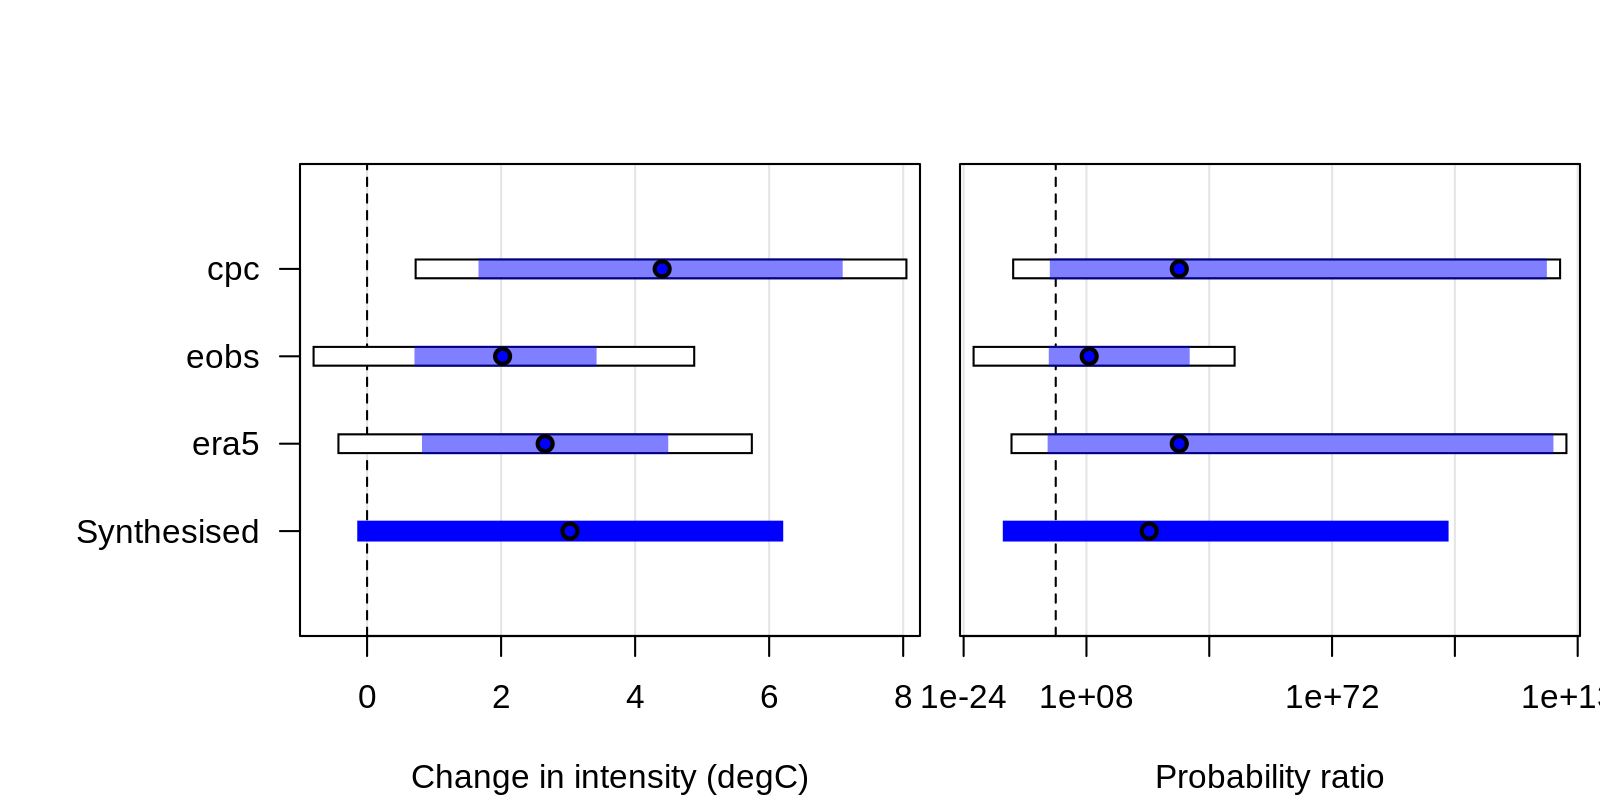

In [36]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# run synthesis
res_dI <- data.frame(res_obs[,grepl("dI.abs.pi", colnames(res_obs))])
synth_dI <- synthesis(obs_in = res_dI, models_in = res_dI, synth_type = "abs")$df[1:(nobs+1),3:7]

res_pr <- infer_infinite(data.frame(res_obs[,grepl("PR.pi", colnames(res_obs))]))
synth_pr <- synthesis(obs_in = res_pr, models_in = res_pr, synth_type = "PR")$df[1:(nobs+1),3:7]

nobs <- nrow(res_dI)

data.frame("dI" = apply(round(synth_dI[,1:3], 2), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")),
           "PR" = apply(signif(synth_pr[,1:3], 3), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")),
                 row.names = c(rownames(res_obs), "Synthesised"))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
prep_window(c(1,2), oma = c(0,7,0,0), mar = c(4.1,0.5,4.1,0.5))
yy <- (nobs+1):1

matplot(synth_dI, yy, type = "n", ylim = c(0,nobs+2), xlab = "Change in intensity (degC)", ylab = "", yaxt = "n")
axis(2, at = yy, labels = c(rownames(res_obs), "Synthesised"), las = 1)

grid(ny = NA, col = adjustcolor("black", 0.1), lty = 1)
abline(v = 0, lty = 2)
segments(y0 = yy, x0 = synth_dI$l_wb, x1 = synth_dI$u_wb, lwd = 10, col = "black", lend = 2)
segments(y0 = yy, x0 = synth_dI$l_wb, x1 = synth_dI$u_wb, lwd = 8, col = "white", lend = 2)
segments(y0 = yy, x0 = synth_dI$lower, x1 = synth_dI$upper, lwd = 10, col = mapply(adjustcolor, "blue", c(rep(0.5,nobs),1)), lend = 2)
points(synth_dI$est, yy, pch = 21, bg = "blue", lwd = 2)


matplot(synth_pr, yy, type = "n", ylim = c(0,nobs+2), xlab = "Probability ratio", ylab = "", yaxt = "n", log = "x")
grid(ny = NA, col = adjustcolor("black", 0.1), lty = 1)
abline(v = 1, lty = 2)
segments(y0 = yy, x0 = synth_pr$l_wb, x1 = synth_pr$u_wb, lwd = 10, col = "black", lend = 2)
segments(y0 = yy, x0 = synth_pr$l_wb, x1 = synth_pr$u_wb, lwd = 8, col = "white", lend = 2)
segments(y0 = yy, x0 = synth_pr$lower, x1 = synth_pr$upper, lwd = 10, col = mapply(adjustcolor, "blue", c(rep(0.5,nobs),1)), lend = 2)
points(synth_pr$est, yy, pch = 21, bg = "blue", lwd = 2)

---

# Quantile regression - how is temperature distribution changing?

In [49]:
suppressMessages(library(quantreg))

In [50]:
ts <- read.csv("data/tx-daily_era5.csv")
ts$year <- substr(ts$time,1,4)
ts <- merge(ts, gmst)

In [40]:
qq <- seq(0.05,0.95,0.1)
qrfit <- rq(tmax ~ gmst, data = ts, tau = qq)
qr_ests <- predict(qrfit, newdata = gmst)
res <- summary(qrfit, se = "boot", covariance = T)

In [41]:
coef <- sapply(res, "[", "coefficients")
beta <- sapply(coef,"[","gmst","Value")
beta_se <- sapply(coef,"[","gmst","Std. Error")

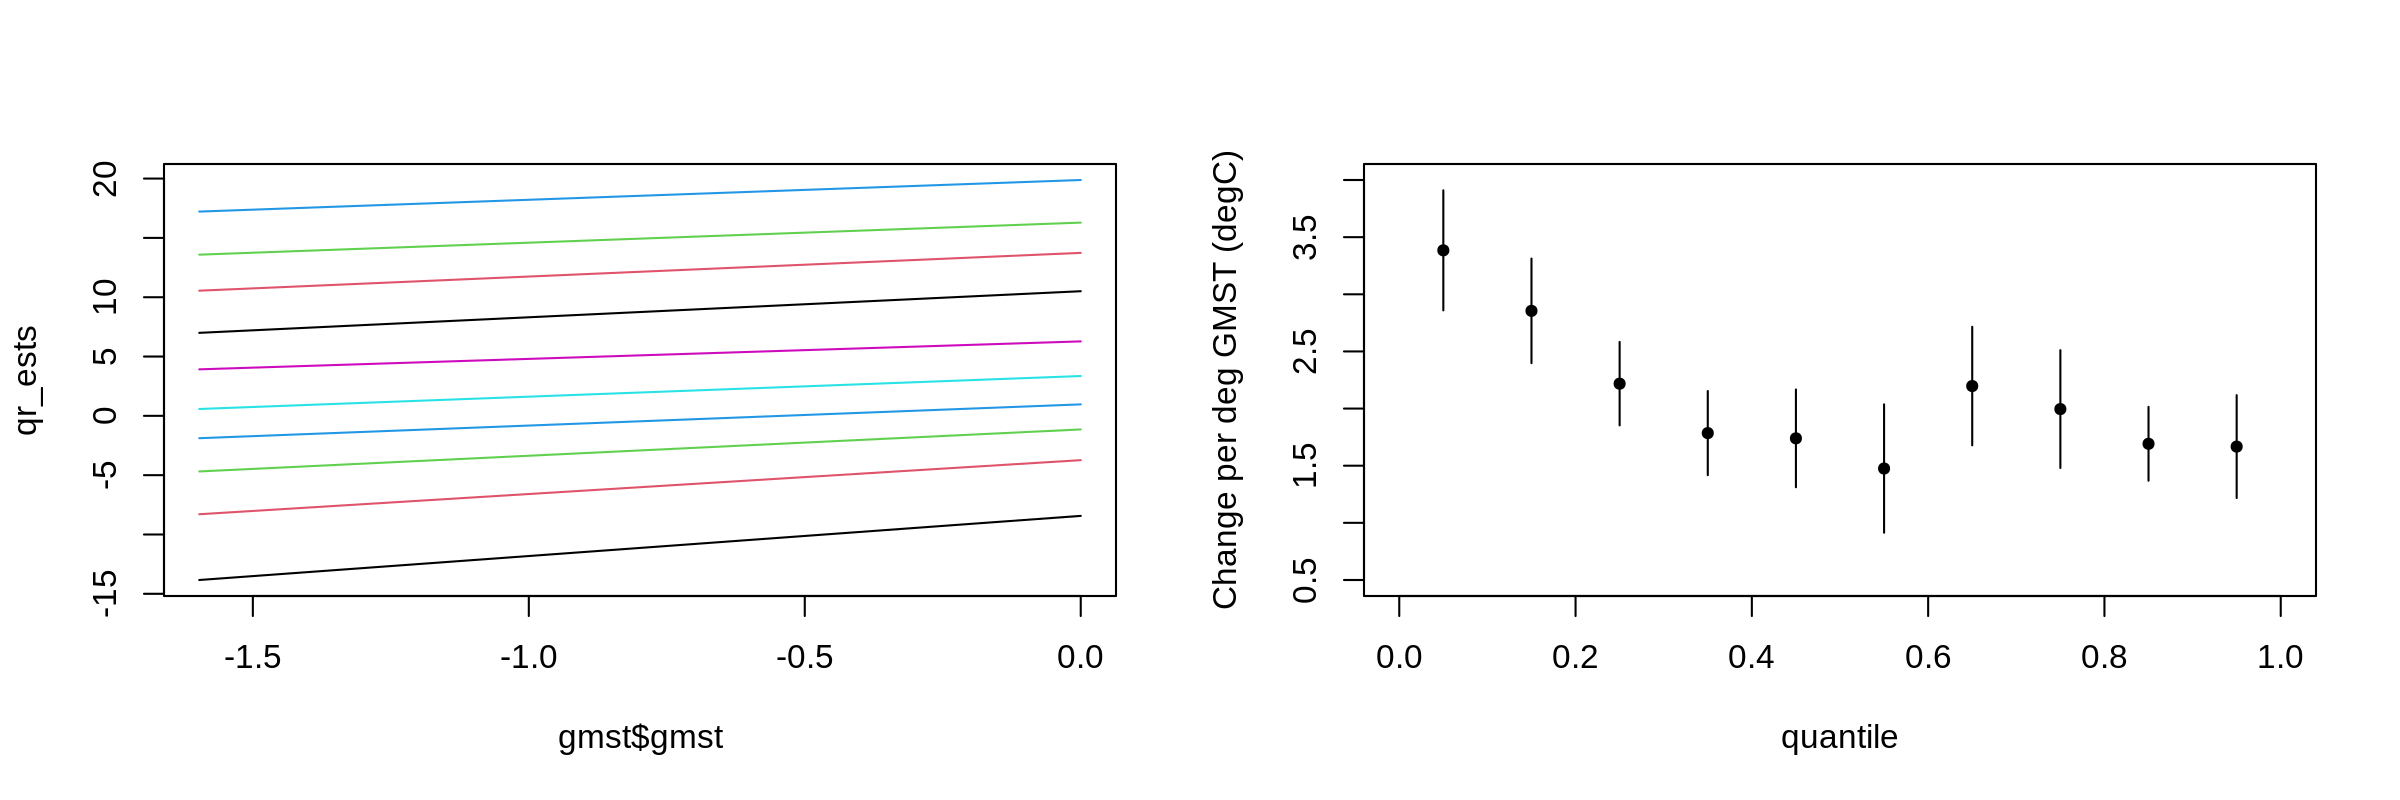

In [42]:
prep_window(c(1,2), w = 6)
matplot(x = gmst$gmst, qr_ests, type = "l", lty = 1)

plot(qq, beta, xlim = c(0,1), ylim = range(pretty(c(beta + (1.96 * beta_se), beta - (1.96 * beta_se)))),
     xlab = "quantile", ylab = "Change per deg GMST (degC)")
segments(x0 = qq, y0 = beta - (1.96 * beta_se), y1 = beta + (1.96 * beta_se))

# Exceedances of a quantile - are heatwaves getting longer?

No indication that number of heatwave days (vs a moving threshold) is increasing so unlikely that length of heatwaves is increasing?

In [1]:
suppressMessages(library(quantreg))

In [42]:
ts <- read.csv("data/tx-daily_era5.csv")
ts$year <- as.integer(substr(ts$time,1,4))
ts <- merge(ts, gmst)

ts$q90 <- predict(rq(tmax ~ gmst, data = ts, tau = 0.9))
ts$ex90 <- (ts$tmax - ts$q90) > 0

In [44]:
ts <- merge(ts, setNames(aggregate(ts$tmax, by = list("year" = ts$year), FUN = quantile, 0.9), c("year", "q90_ann")))
ts$ex_ann <- (ts$tmax - ts$q90_ann) > 0

In [45]:
write.csv(ts, "data/threshold-excesses_era5_tmax.csv", row.names = F)

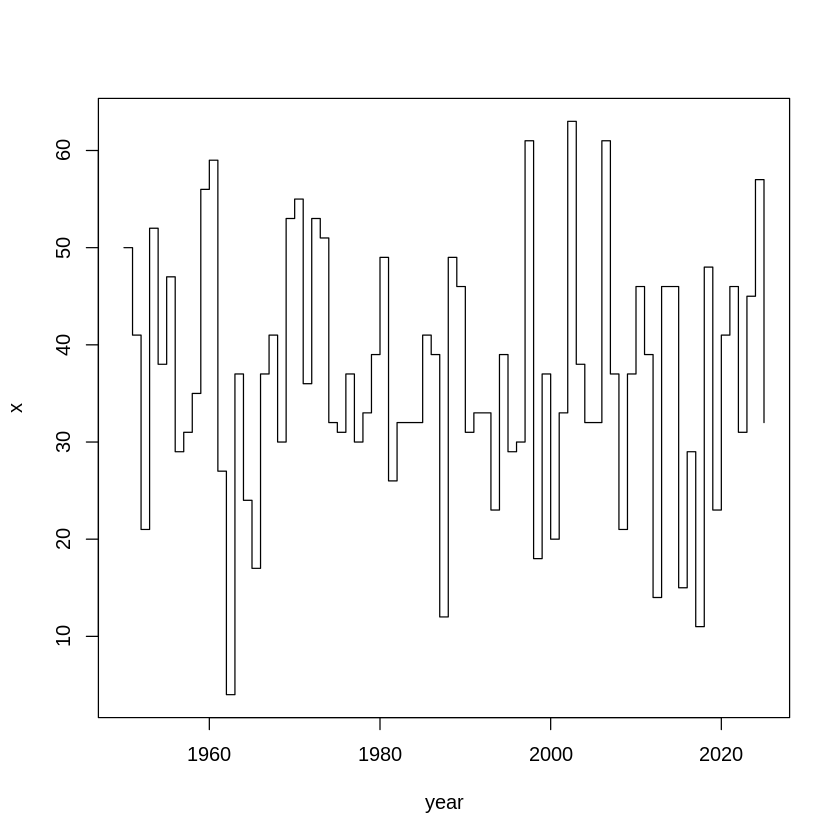

In [11]:
plot(aggregate(ts$ex90, by = list("year" = ts$year), FUN = sum), type = "s")

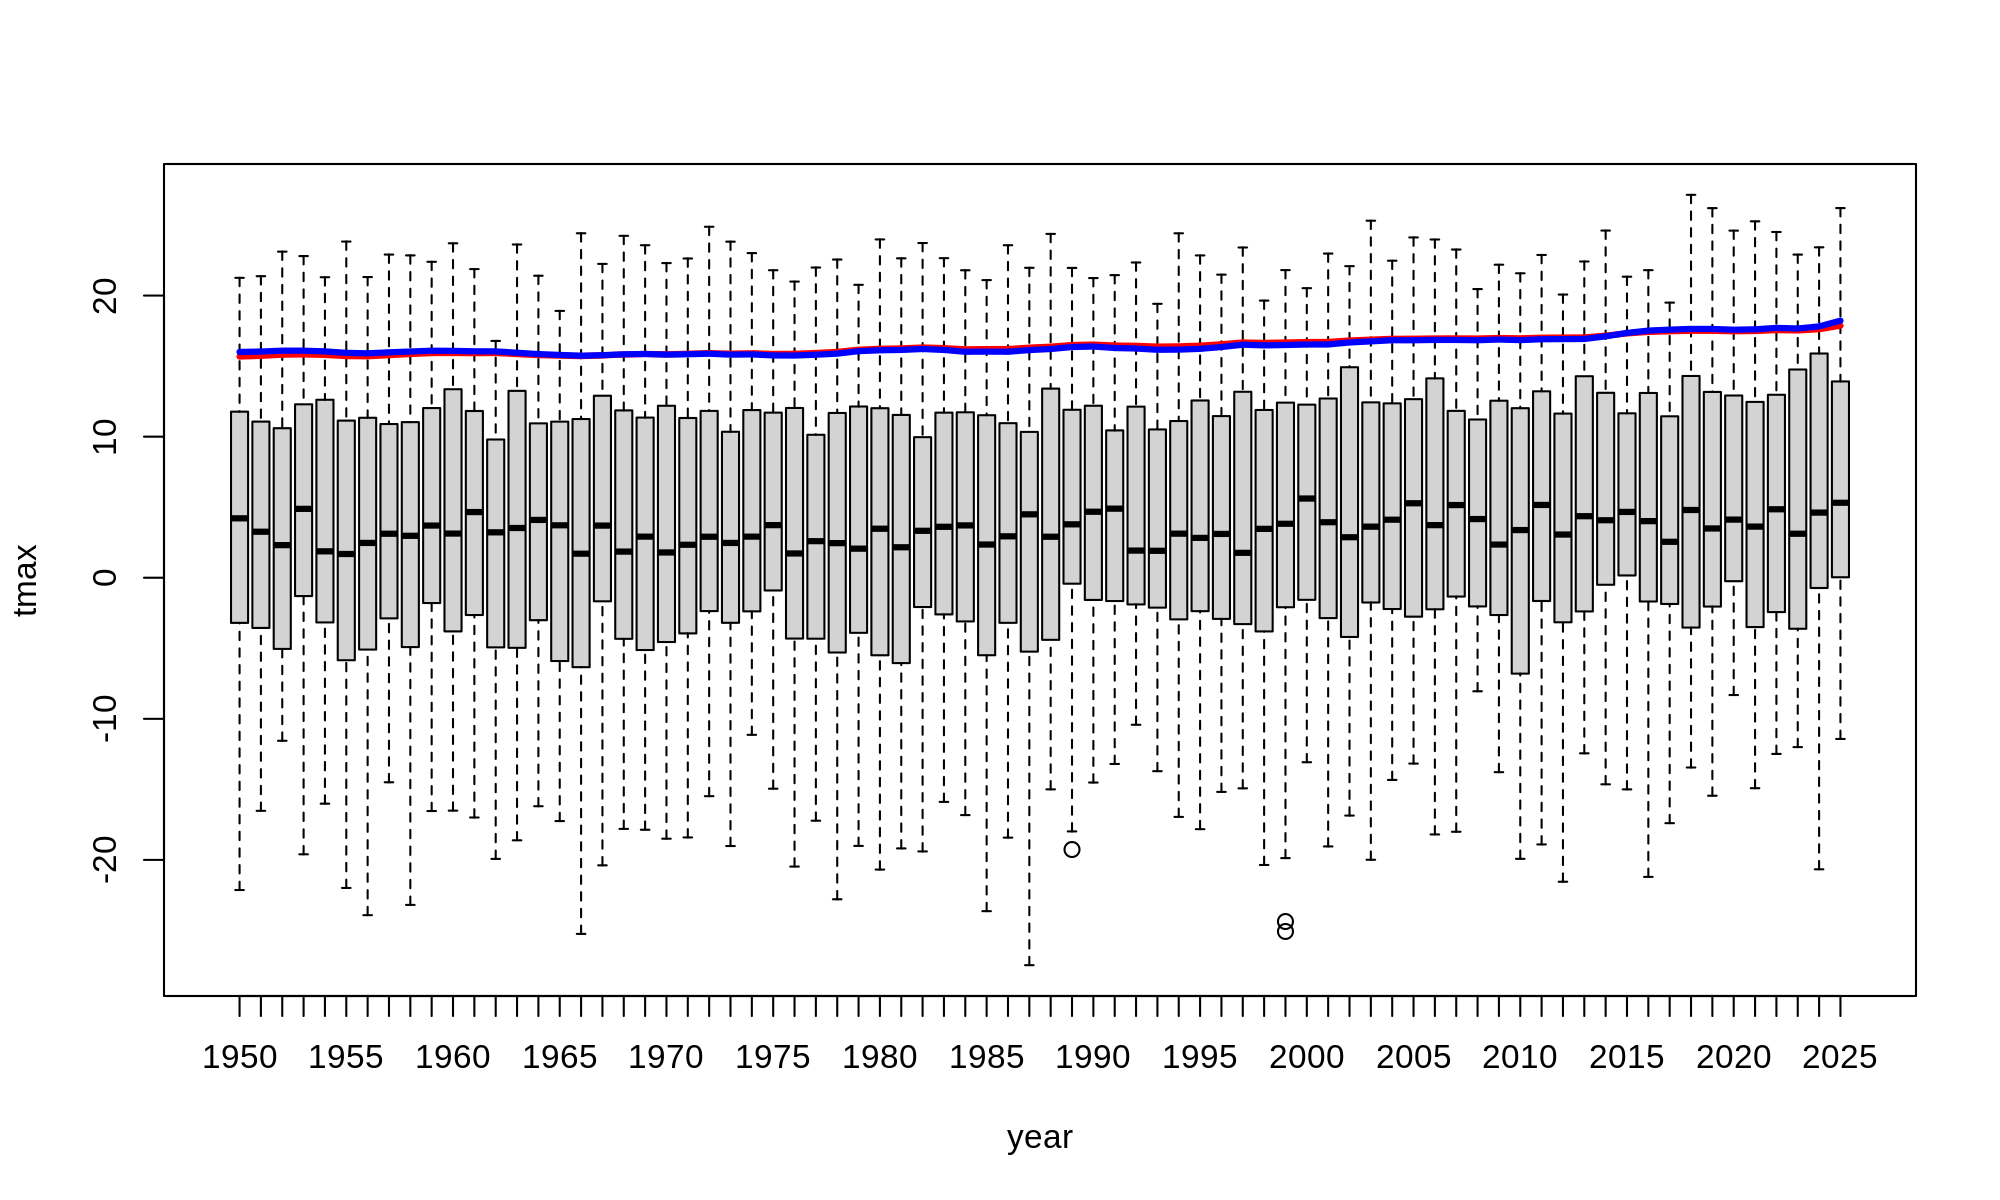

In [36]:
boxplot(tmax ~ year, ts)#
lines(predict(rq(tmax ~ gmst, data = ts, tau = 0.9), newdata = gmst[gmst$year >= 1950,"gmst",drop = F]), col = "red", lwd = 3)

lines(predict(rq(tmax ~ gmst*year, data = ts, tau = 0.9), newdata = gmst[gmst$year >= 1950,c("gmst","year"),drop = F]), col = "blue", lwd = 3)

# Trend fitting at stations

In [337]:
varnm <- "tx14x"
country <- "SE"
nsamp <- 1000

In [123]:
# load GMST time series (annual, 4-year smoothed)
gmst <- read.table("ts/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

cov_f <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_cf <- rbind("pi" = cov_f - 1.3,
                "2000" = cov_f - 0.65,
                "2018" = gmst$gmst[gmst$year == 2018])

## Fit model

In [127]:
for(varnm in c("tx14x", "tn14x")) {
    for(country in c("SE", "FI")) {
        
        stn_tx <- read.csv(paste0("stations/stations-",country,"_",varnm,".csv"))
        colnames(stn_tx) <- gsub("time", "year", colnames(stn_tx))

        for (cnm in colnames(stn_tx)[-1]) {
            print(cnm)
        
            res_fnm <- paste0("res/res-station_",varnm,"_",country,"-",cnm,".csv")
            if(file.exists(res_fnm)) next
            df_c <- stn_tx[,c("year", cnm)]
            df_c <- df_c[!is.na(df_c[,cnm]),]
            df_c <- merge(gmst, df_c)
        
            mdl <- fit_ns("gev", "shift", df_c, cnm, "gmst")
        
            # need to account for stations without 2025
        
            res <- boot_ci(mdl, cov_f = cov_f, cov_cf = cov_cf, nsamp = nsamp)
            write.csv(res, res_fnm)
        
            png(gsub("csv", "png", gsub("res/", "stations/fig/", res_fnm)), h = 360, w = 360 * 3); {
                prep_window(c(1,3))
                plot_trend(mdl, ev_year = 2025)
                plot_covtrend(mdl, "gmst", ci_cov = rbind(cov_f, cov_cf), nsamp = 100, ev_x = 0)
                plot_returnlevels(mdl, cov_f, cov_cf["pi",,drop = F])
            }; dev.off()
        }   
    }
}
print("Done.")

[1] "haparanda"
[1] "pitea"
[1] "tmax"
[1] "haparanda"
[1] "pitea"
[1] "tmin"
[1] "Done."


## Compile obs results

In [382]:
varnm = "tn14x"

# quick loop over all files to check years covered
ts_length <- do.call("rbind", sapply(c("NO", "SE", "FI"), function(country) {
    df = read.csv(paste0("stations/stations-",country, "_", varnm, ".csv"))
    colnames(df) <- gsub("time", "year", colnames(df))
    t(sapply(colnames(df)[-1], function(cnm) c(paste0(country,"-",cnm),range(df[!is.na(df[,cnm]), "year"]))))
}))

# load fitted model results
res_obs <- t(sapply(list.files("res", pattern = paste0("res-station_",varnm), full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))

In [383]:
res_obs

[1,]

In [ ]:
rownames(res_obs) <- gsub(".csv", "", sapply(strsplit(rownames(res_obs), "_"), "[", 3))

In [ ]:
write.csv(res_obs, paste0("res-stations_",varnm,".csv"))

## Quick plots

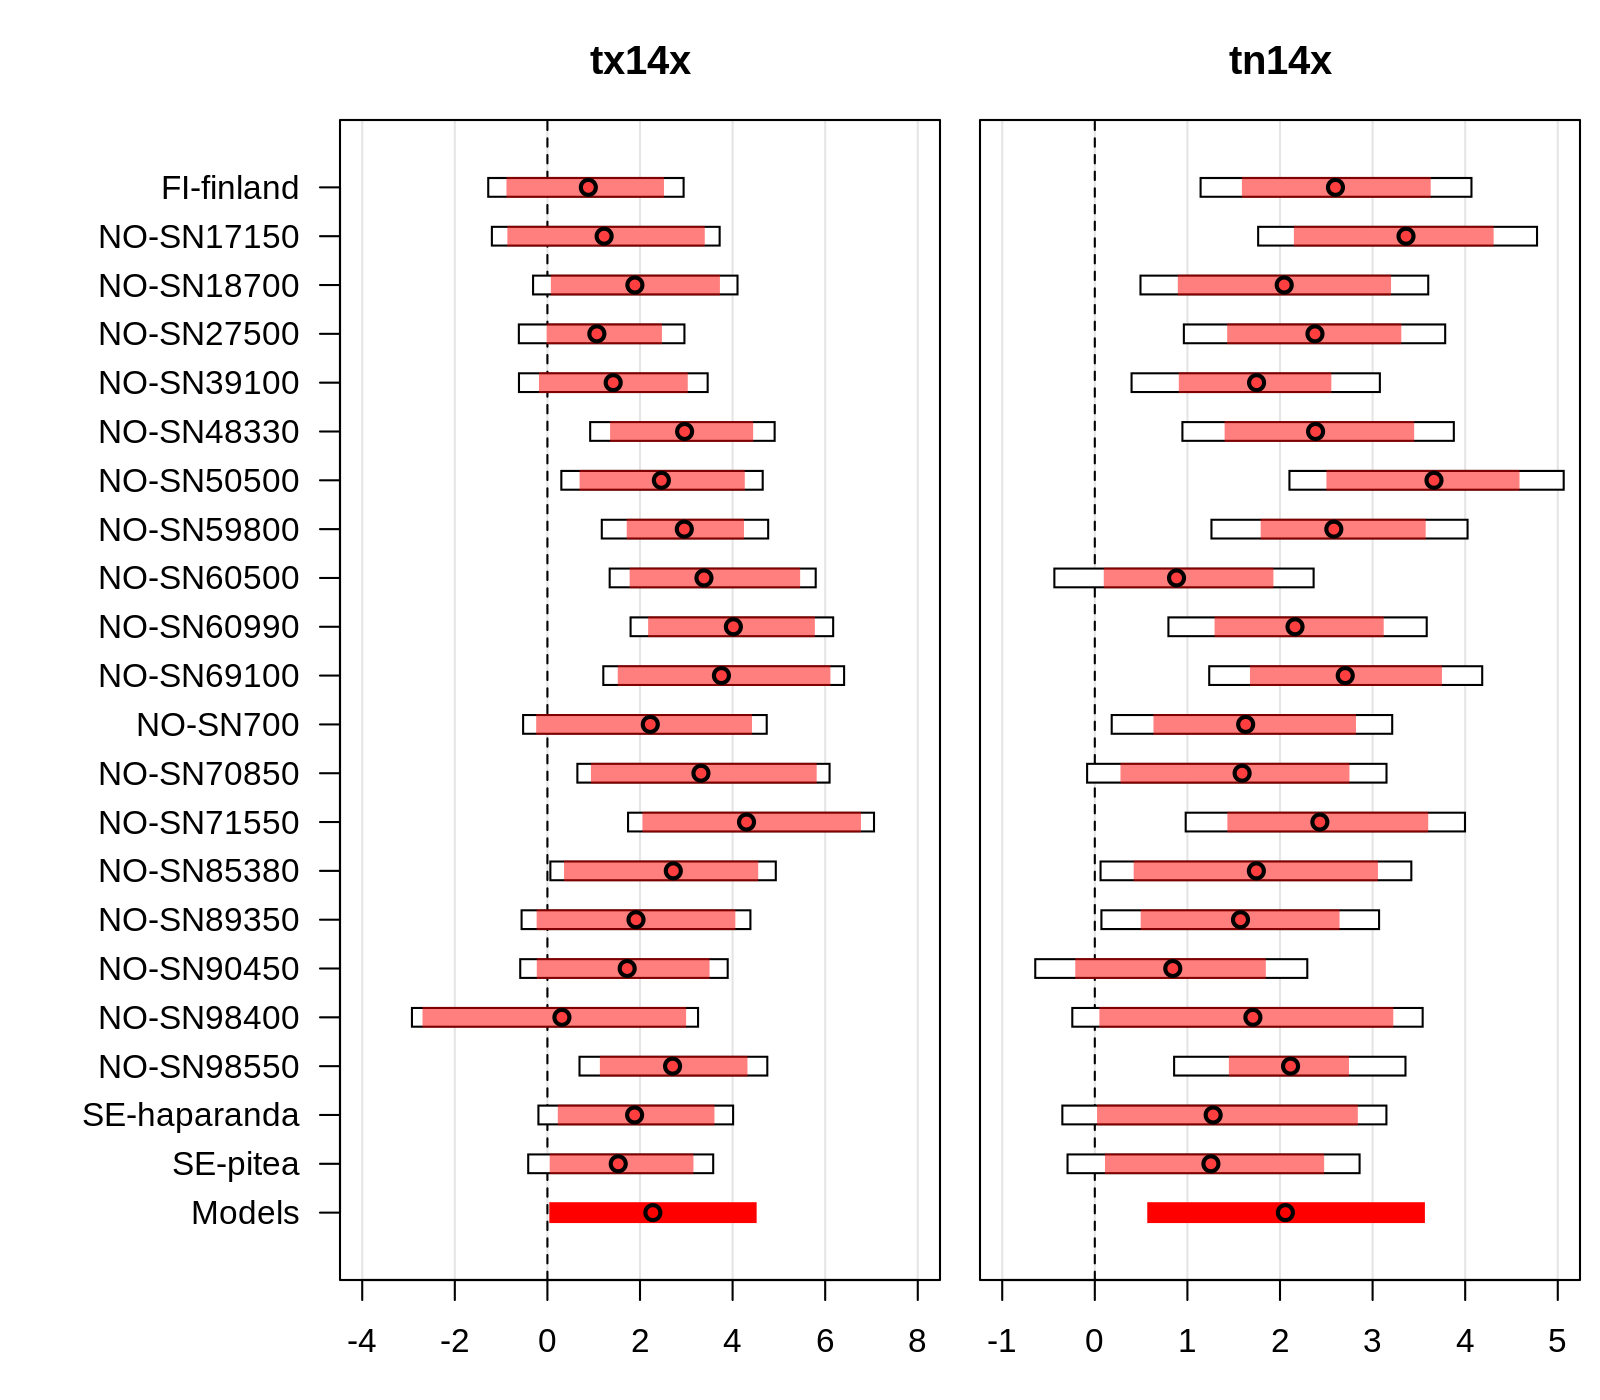

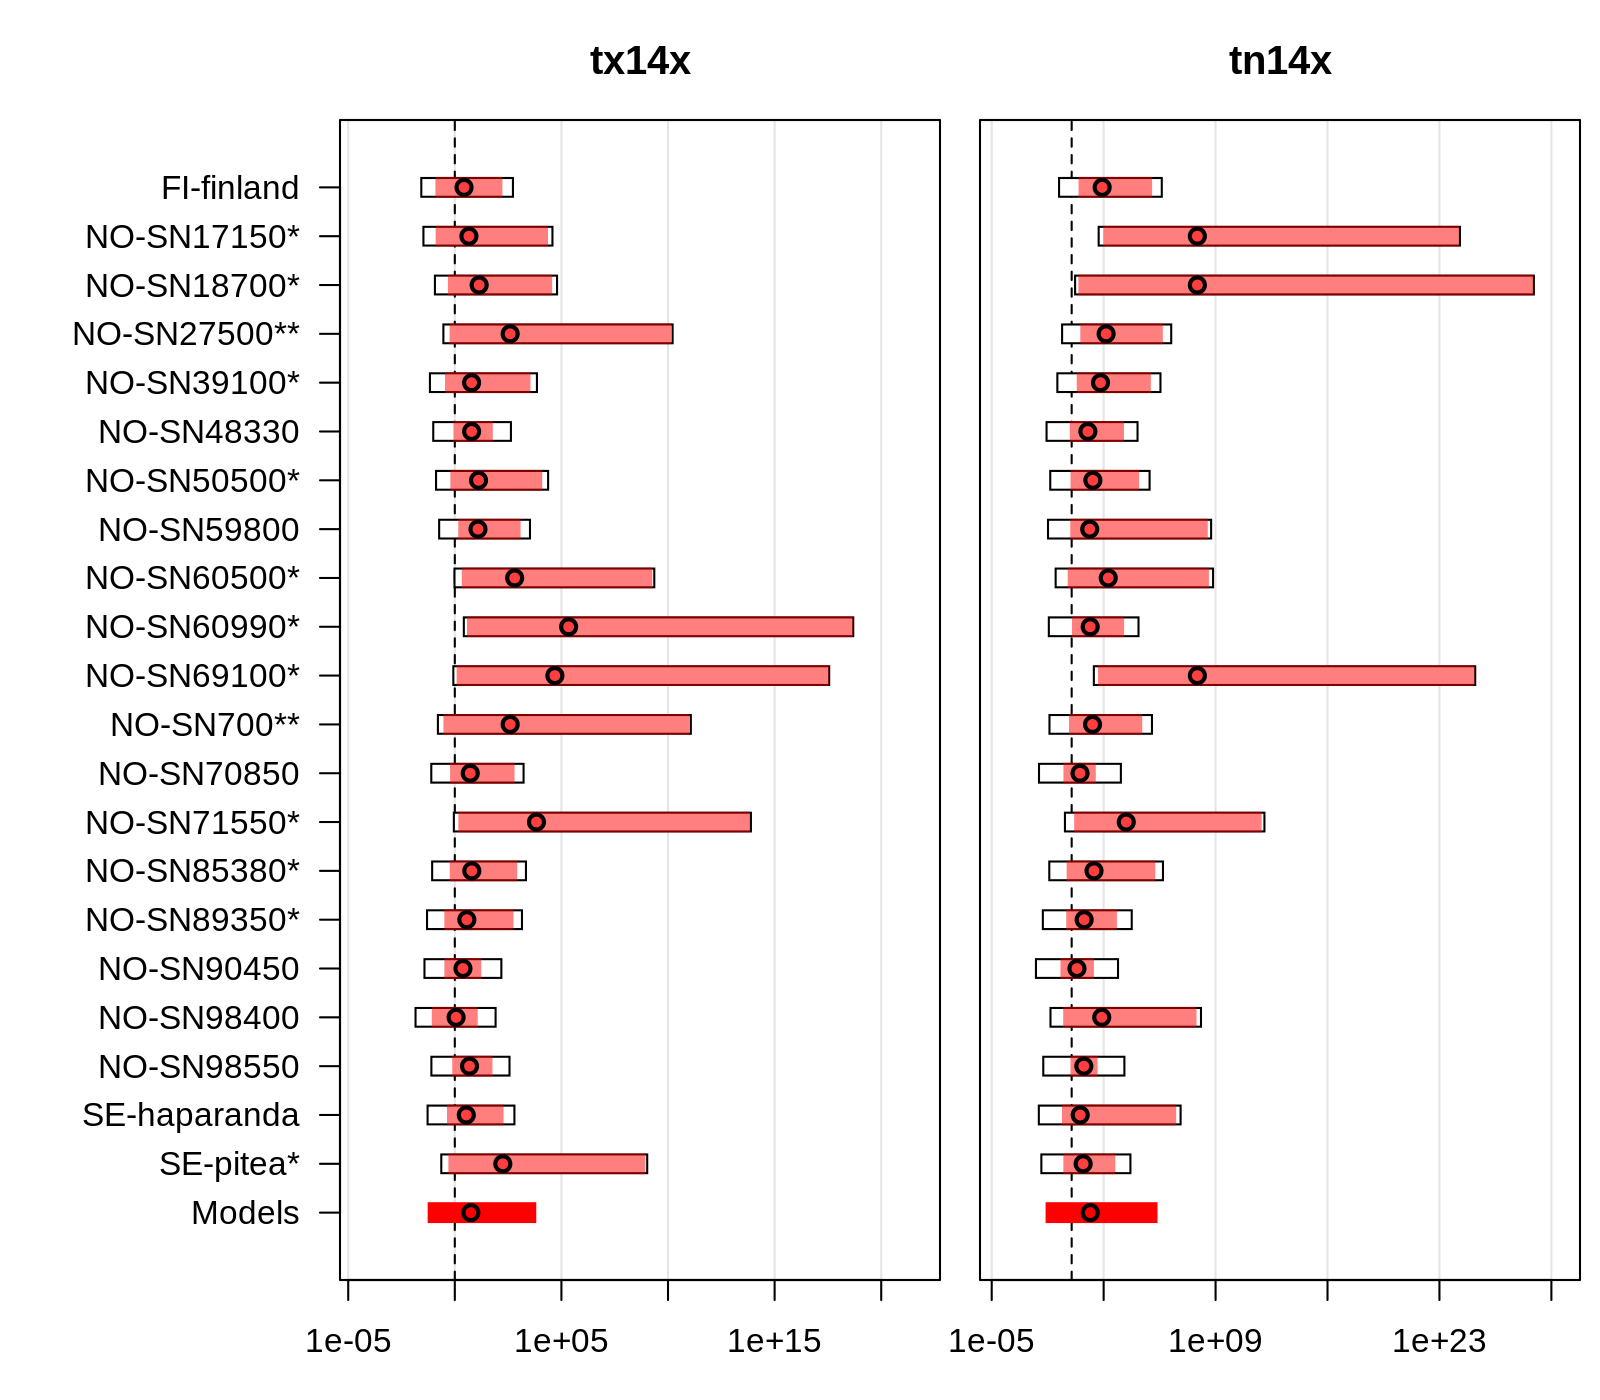

In [399]:
res_tn = read.csv("res-stations_tn14x.csv", row.names = "X")
res_tx = read.csv("res-stations_tx14x.csv", row.names = "X")

res_tn <- res_tn[-which(rownames(res_tn) == "NO-SN46610"),]
res_tx <- res_tx[-which(rownames(res_tx) == "NO-SN46610"),]

# png("fig/stations_intensity-change.png", h = 480, w = 360*2); {
    prep_window(c(1,2), oma = c(0,8,0,0), w = 4, h = 7, mar = c(3,0.5,3,0.5))
    plot_synthesis(synthesis(models_in = res_tx[grepl("dI.abs.pi", colnames(res_tx))]), main = "tx14x")
    plot_synthesis(synthesis(models_in = res_tn[grepl("dI.abs.pi", colnames(res_tn))]), main = "tn14x", hide_labels = T)
# }; dev.off()

# png("fig/stations_probability-ratio.png", h = 480, w = 360*2); {
    prep_window(c(1,2), oma = c(0,8,0,0), w = 4, h = 7, mar = c(3,0.5,3,0.5))
    plot_synthesis(synthesis(models_in = infer_infinite(res_tx[grepl("PR.pi", colnames(res_tx))]), synth_type = "PR"), main = "tx14x", log = T)
    plot_synthesis(synthesis(models_in = infer_infinite(res_tn[grepl("PR.pi", colnames(res_tn))]), synth_type = "PR"),
               main = "tn14x", log = T, hide_labels = T)
# }; dev.off()

In [396]:
5.635516e+00

[1] 5.635516